# Clustering Assignment

#### K-Means Clustering

**Overview**<br>
Given the datset of countries with socioeconomic and health information. Categorise the countries using some socio-economic and health factors that determine the overall development of the country. Also, suggest the countries which needs more focus.

The steps are broadly:

1. Read and understand the data
2. Clean the data
3. Prepare the data for modelling
4. Modelling
5. Final analysis and reco

# 1. Read and Visualize the data

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime as dt

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [7]:
# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

##### Read the dataset

In [8]:
df_country = pd.read_csv("Country-data.csv", sep=",", encoding="ISO-8859-1", header=0)

In [9]:
df_country.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [10]:
df_country.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   country     167 non-null    object 
 1   child_mort  167 non-null    float64
 2   exports     167 non-null    float64
 3   health      167 non-null    float64
 4   imports     167 non-null    float64
 5   income      167 non-null    int64  
 6   inflation   167 non-null    float64
 7   life_expec  167 non-null    float64
 8   total_fer   167 non-null    float64
 9   gdpp        167 non-null    int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


In [11]:
df_country.columns

Index(['country', 'child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp'],
      dtype='object')

In [12]:
df_country.shape

(167, 10)

# 2. Clean the data

- Check for missing values
- Check for outliers

In [13]:
# missing values
round(100*(df_country.isnull().sum())/len(df_country), 2)

country       0.0
child_mort    0.0
exports       0.0
health        0.0
imports       0.0
income        0.0
inflation     0.0
life_expec    0.0
total_fer     0.0
gdpp          0.0
dtype: float64

<a We can see that there is no missing values in the dataset a>

-- We can observe that there is no missing values in the dataset

- So this data seems largely clean,but we have a lot of variables and making and visualising proper clusters will be a   difficulty.
- Let's plot the correlation matrix and check if the data is indeed highly correlated

# 3. Prepare the data for modelling

###### Health, import and export are given as percentage values, lets convert them to absolute values based on gdpp

In [14]:
#Converting exports,imports and health spending percentages to absolute values.
df_country['exports'] = df_country['exports']*df_country['gdpp']/100
df_country['imports'] = df_country['imports']*df_country['gdpp']/100
df_country['health'] = df_country['health']*df_country['gdpp']/100

In [15]:
df_country.head()

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,Albania,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,Angola,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


- Lets check the correlation matrix and Heatmap

In [16]:
df_country.corr()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
child_mort,1.000000,-0.297230,-0.430438,-0.319138,-0.524315,0.288276,-0.886676,0.848478,-0.483032
exports,-0.297230,1.000000,0.612919,0.987686,0.725351,-0.141553,0.377694,-0.291096,0.768894
health,-0.430438,0.612919,1.000000,0.638581,0.690857,-0.253956,0.545626,-0.407984,0.916593
imports,-0.319138,0.987686,0.638581,1.000000,0.672056,-0.179458,0.397515,-0.317061,0.755114
income,-0.524315,0.725351,0.690857,0.672056,1.000000,-0.147756,0.611962,-0.501840,0.895571
inflation,0.288276,-0.141553,-0.253956,-0.179458,-0.147756,1.000000,-0.239705,0.316921,-0.221631
life_expec,-0.886676,0.377694,0.545626,0.397515,0.611962,-0.239705,1.000000,-0.760875,0.600089
total_fer,0.848478,-0.291096,-0.407984,-0.317061,-0.501840,0.316921,-0.760875,1.000000,-0.454910
gdpp,-0.483032,0.768894,0.916593,0.755114,0.895571,-0.221631,0.600089,-0.454910,1.000000


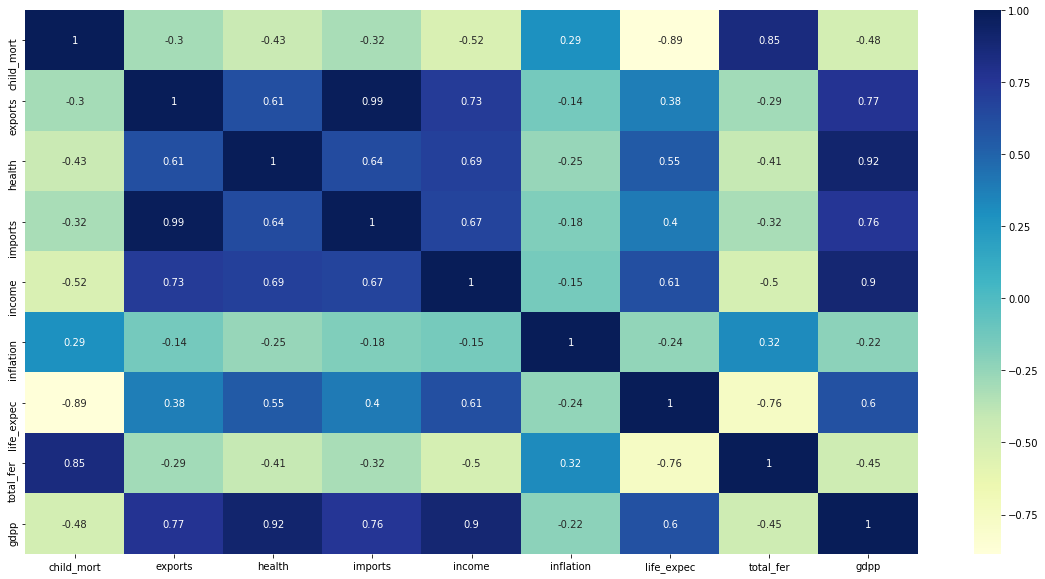

In [17]:
plt.figure(figsize = (20,10))        
sns.heatmap(df_country.corr(),annot = True, cmap="YlGnBu")

We observe the following correlations from the plot.

- gdpp and income are most highly correlated with correlation of 0.9
- child_mortality and life_expentency are highly correlated with correlation of -0.89
- child_mortality and total_fertility are highly correlated with correlation of 0.85
- imports and exports are highly correlated with correlation of 0.74
- life_expentency and total_fertility are highly correlated with correlation of -0.76

In [18]:
#The final matrix would only contain the data columns. Hence let's drop the country column
data=df_country.drop(['country'],axis=1)
data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,55.30,41.9174,248.297,1610,9.44,56.2,5.82,553
1,16.6,1145.20,267.8950,1987.740,9930,4.49,76.3,1.65,4090
2,27.3,1712.64,185.9820,1400.440,12900,16.10,76.5,2.89,4460
3,119.0,2199.19,100.6050,1514.370,5900,22.40,60.1,6.16,3530
4,10.3,5551.00,735.6600,7185.800,19100,1.44,76.8,2.13,12200


- we observe that a lot of the data variables are of different orders of magnitude. 
- Let's standardise the values using Standard Scaler

In [19]:
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
df_c = standard_scaler.fit_transform(data)

In [20]:
df_c.shape

(167, 9)

# EDA

Univariate Analysis

We need to choose the countries that are in the direst need of aid. Hence, we need to identify those countries with using some socio-economic and health factors that determine the overall development of the country.

We will have a look on the lowest 10 countries for each factor.

1. **Child Mortality Rate** : Death of children under 5 years of age per 1000 live births
2. **Fertility Rate**: The number of children that would be born to each woman if the current age-fertility rates remain the same
3. **Life Expectancy**: The average number of years a new born child would live if the current mortality patterns are to remain same
4. **Health** :Total health spending as %age of Total GDP.
5. **The GDP per capita** : Calculated as the Total GDP divided by the total population.
6. **Per capita Income** : Net income per person
7. **Inflation**: The measurement of the annual growth rate of the Total GDP
8. **Exports:** Exports of goods and services. Given as %age of the Total GDP
9. **Imports:** Imports of goods and services. Given as %age of the Total GDP

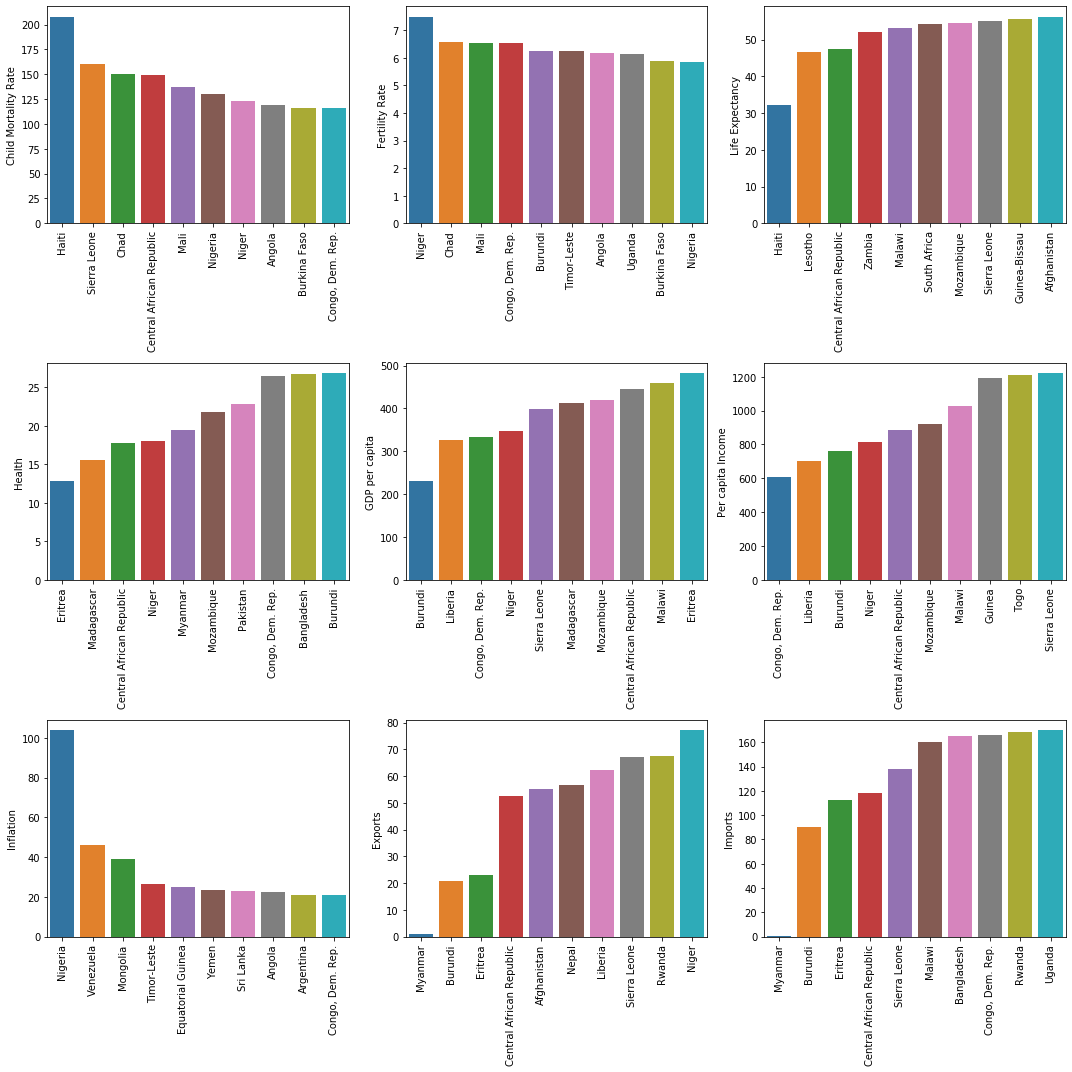

In [21]:
fig, axs = plt.subplots(3,3,figsize = (15,15))

# Child Mortality Rate : Death of children under 5 years of age per 1000 live births

top10_child_mort = df_country[['country','child_mort']].sort_values('child_mort', ascending = False).head(10)
plt1 = sns.barplot(x='country', y='child_mort', data= top10_child_mort, ax = axs[0,0])
plt1.set(xlabel = '', ylabel= 'Child Mortality Rate')

# Fertility Rate: The number of children that would be born to each woman if the current age-fertility rates remain the same
top10_total_fer = df_country[['country','total_fer']].sort_values('total_fer', ascending = False).head(10)
plt1 = sns.barplot(x='country', y='total_fer', data= top10_total_fer, ax = axs[0,1])
plt1.set(xlabel = '', ylabel= 'Fertility Rate')

# Life Expectancy: The average number of years a new born child would live if the current mortality patterns are to remain same

bottom10_life_expec = df_country[['country','life_expec']].sort_values('life_expec', ascending = True).head(10)
plt1 = sns.barplot(x='country', y='life_expec', data= bottom10_life_expec, ax = axs[0,2])
plt1.set(xlabel = '', ylabel= 'Life Expectancy')

# Health :Total health spending as %age of Total GDP.

bottom10_health = df_country[['country','health']].sort_values('health', ascending = True).head(10)
plt1 = sns.barplot(x='country', y='health', data= bottom10_health, ax = axs[1,0])
plt1.set(xlabel = '', ylabel= 'Health')

# The GDP per capita : Calculated as the Total GDP divided by the total population.

bottom10_gdpp = df_country[['country','gdpp']].sort_values('gdpp', ascending = True).head(10)
plt1 = sns.barplot(x='country', y='gdpp', data= bottom10_gdpp, ax = axs[1,1])
plt1.set(xlabel = '', ylabel= 'GDP per capita')

# Per capita Income : Net income per person

bottom10_income = df_country[['country','income']].sort_values('income', ascending = True).head(10)
plt1 = sns.barplot(x='country', y='income', data= bottom10_income, ax = axs[1,2])
plt1.set(xlabel = '', ylabel= 'Per capita Income')


# Inflation: The measurement of the annual growth rate of the Total GDP

top10_inflation = df_country[['country','inflation']].sort_values('inflation', ascending = False).head(10)
plt1 = sns.barplot(x='country', y='inflation', data= top10_inflation, ax = axs[2,0])
plt1.set(xlabel = '', ylabel= 'Inflation')


# Exports: Exports of goods and services. Given as %age of the Total GDP

bottom10_exports = df_country[['country','exports']].sort_values('exports', ascending = True).head(10)
plt1 = sns.barplot(x='country', y='exports', data= bottom10_exports, ax = axs[2,1])
plt1.set(xlabel = '', ylabel= 'Exports')


# Imports: Imports of goods and services. Given as %age of the Total GDP

bottom10_imports = df_country[['country','imports']].sort_values('imports', ascending = True).head(10)
plt1 = sns.barplot(x='country', y='imports', data= bottom10_imports, ax = axs[2,2])
plt1.set(xlabel = '', ylabel= 'Imports')

for ax in fig.axes:
    plt.sca(ax)
    plt.xticks(rotation = 90)
    
plt.tight_layout()
plt.savefig('eda')
plt.show()

**Observations**
1. Haiti has highest child mortality rate and least Life expectatncy.
2. Niger has highest Fertility Rate.
3. Eritrea has lowest spending on Health.
4. Burundi has lowest GDP per capita
5. The republic of Congo has lowest Per Capita Income
6. Inflation rates of Nigeria are the highest
7. Myanmar doesn't export or import much(lowest exports and imports)

### Outlier Analysis
We will see how values in each columns are distributed using boxplot

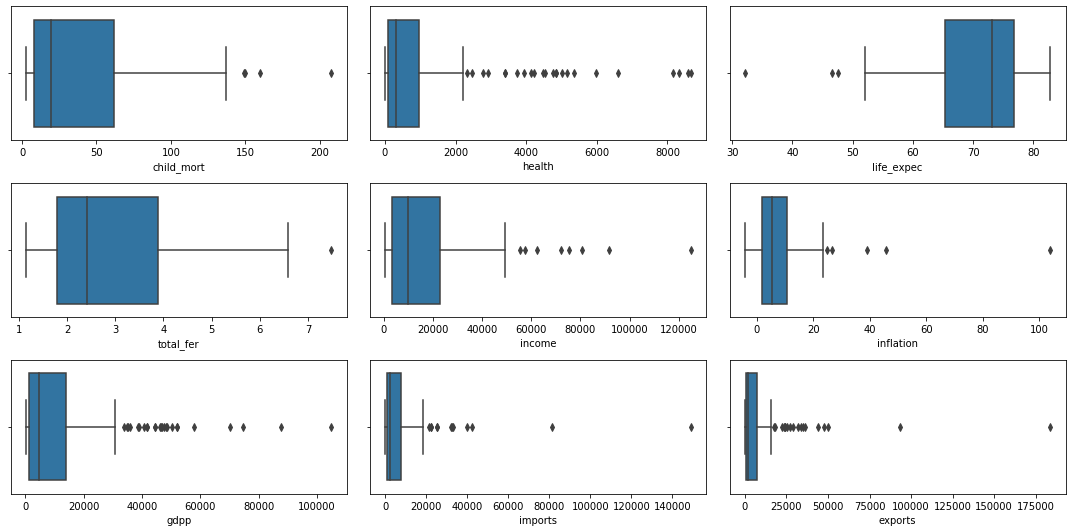

In [22]:
fig, axs = plt.subplots(3,3, figsize = (15,7.5))
plt1 = sns.boxplot(df_country['child_mort'], ax = axs[0,0])
plt2 = sns.boxplot(df_country['health'], ax = axs[0,1])
plt3 = sns.boxplot(df_country['life_expec'], ax = axs[0,2])
plt4 = sns.boxplot(df_country['total_fer'], ax = axs[1,0])
plt5 = sns.boxplot(df_country['income'], ax = axs[1,1])
plt6 = sns.boxplot(df_country['inflation'], ax = axs[1,2])
plt7 = sns.boxplot(df_country['gdpp'], ax = axs[2,0])
plt8 = sns.boxplot(df_country['imports'], ax = axs[2,1])
plt9 = sns.boxplot(df_country['exports'], ax = axs[2,2])


plt.tight_layout()

We observe the following about the outliers.

- All variables have outliers on the upper side (higher values) except for life_expec which has outliers on the down side (less values) indicating that usually the life expectancy in most countries is above 50 except for 3 countries.

In [23]:
df_country.describe()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,183750.000000,8663.600000,149100.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


- As we can see there are a number of outliers in the data.
- Keeping in mind we need to identify backward countries based on socio economic and health factors.
- We will cap the outliers to values accordingly for analysis.

In [24]:
data_c = ['child_mort', 'exports', 'health', 'imports', 'income',
       'inflation', 'life_expec', 'total_fer', 'gdpp']

for i in data_c:
    percentiles = data[i].quantile([0.05, 0.95]).values
    data[i][data[i] <= percentiles[0]] = percentiles[0]
    data[i][data[i] >= percentiles[1]] = percentiles[1]

In [25]:
data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,90.2,70.4688,41.9174,248.297,1610.0,9.44,56.2,5.820,553.0
1,16.6,1145.2000,267.8950,1987.740,9930.0,4.49,76.3,1.650,4090.0
2,27.3,1712.6400,185.9820,1400.440,12900.0,16.10,76.5,2.890,4460.0
3,116.0,2199.1900,100.6050,1514.370,5900.0,20.87,60.1,5.861,3530.0
4,10.3,5551.0000,735.6600,7185.800,19100.0,1.44,76.8,2.130,12200.0


###### There are 2 types of outliers
1. Domain specific
2. Statistical

Let's treat statistical outliers

In [26]:
# Treating (statistical) outliers
grouped_df = df_country.groupby('country')['income'].sum()
grouped_df = grouped_df.reset_index()
grouped_df.head()

,country,income
0,Afghanistan,1610
1,Albania,9930
2,Algeria,12900
3,Angola,5900
4,Antigua and Barbuda,19100


In [27]:
Q1 = grouped_df.income.quantile(0.05)
Q3 = grouped_df.income.quantile(0.95)
IQR = Q3 - Q1
grouped_df = grouped_df[(grouped_df.income >= Q1 - 1.5*IQR) & (grouped_df.income <= Q3 + 1.5*IQR)]

###### Rescaling the data

In [28]:
standard_scaler = StandardScaler()
df_scaled = standard_scaler.fit_transform(data)
df_scaled.shape

(167, 9)

# 4. Clustering

#### Hopkin's Score

In [29]:
#Calculating the Hopkins statistic
from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

In [30]:
hopkins(df_country.drop('country', axis = 1))

0.9787693494119407

### - We have a good hopkins score implies that the dataset has high tendency to cluster
- Let's proceed with K-means and Hierarchical Clustering

###### K-means with some arbitatary K

In [31]:
# k-means with some arbitrary k
kmeans = KMeans(n_clusters=4, max_iter=50, random_state=100)
kmeans.fit(df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=100, tol=0.0001, verbose=0)

In [32]:
kmeans.labels_

array([3, 0, 0, 3, 0, 0, 0, 1, 2, 0, 1, 1, 0, 0, 0, 2, 0, 3, 0, 0, 0, 3,
       0, 1, 0, 3, 3, 0, 3, 2, 0, 3, 3, 0, 0, 0, 3, 3, 3, 0, 3, 0, 1, 1,
       2, 0, 0, 0, 0, 3, 3, 1, 0, 2, 1, 3, 3, 0, 2, 3, 1, 0, 0, 3, 3, 0,
       3, 1, 2, 0, 0, 0, 3, 2, 1, 1, 0, 1, 0, 0, 3, 3, 1, 0, 3, 0, 0, 3,
       3, 0, 0, 2, 0, 3, 3, 0, 0, 3, 2, 3, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0,
       2, 1, 3, 3, 2, 1, 3, 0, 0, 0, 0, 0, 1, 2, 0, 0, 3, 0, 1, 3, 0, 0,
       3, 2, 1, 1, 3, 3, 1, 1, 0, 0, 3, 0, 2, 2, 0, 3, 0, 3, 3, 0, 0, 0,
       0, 3, 0, 2, 1, 1, 0, 0, 0, 0, 0, 3, 3])

## Finding optimal number of clusters

#### Sum of squared Distance (SSD)

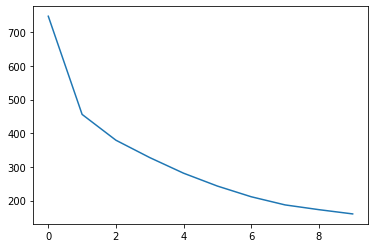

In [33]:
ssd = []
range_n_clusters = [2,3,4,5,6,7,8,9,10,11]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, random_state=50)
    kmeans.fit(df_scaled)
    
    ssd.append(kmeans.inertia_)
    
# plot the SSDs for each n_clusters
# ssd
plt.plot(ssd)

### Silhouette Analysis

$$\text{silhouette score}=\frac{p-q}{max(p,q)}$$

$p$ is the mean distance to the points in the nearest cluster that the data point is not a part of

$q$ is the mean intra-cluster distance to all the points in its own cluster.

* The value of the silhouette score range lies between -1 to 1. 

* A score closer to 1 indicates that the data point is very similar to other data points in the cluster, 

* A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [34]:
# silhouette analysis
range_n_clusters = [2, 3, 4, 5, 6, 7, 8,9,10,11]

for num_clusters in range_n_clusters:
    
    # intialise kmeans
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50, random_state=50)
    kmeans.fit(df_scaled)
    
    cluster_labels = kmeans.labels_
    
    # silhouette score
    silhouette_avg = silhouette_score(df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))
    
    

For n_clusters=2, the silhouette score is 0.48447902987180524
For n_clusters=3, the silhouette score is 0.4203919640787207
For n_clusters=4, the silhouette score is 0.3879858729916906
For n_clusters=5, the silhouette score is 0.3415003731344425
For n_clusters=6, the silhouette score is 0.32393605664054803
For n_clusters=7, the silhouette score is 0.3358873156149782
For n_clusters=8, the silhouette score is 0.3372443481107482
For n_clusters=9, the silhouette score is 0.3271404576724547
For n_clusters=10, the silhouette score is 0.3360913340652756
For n_clusters=11, the silhouette score is 0.30403256931088224


### Model with k=3

In [35]:
# final model with k=3
kmeans = KMeans(n_clusters=3, max_iter=50, random_state=50)
kmeans.fit(df_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=50, tol=0.0001, verbose=0)

In [36]:
kmeans.labels_

array([2, 0, 0, 2, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 2, 0, 0, 0, 2,
       0, 1, 0, 2, 2, 0, 2, 1, 0, 2, 2, 0, 0, 0, 2, 2, 2, 0, 2, 0, 1, 1,
       1, 0, 0, 0, 0, 2, 2, 0, 0, 1, 1, 2, 2, 0, 1, 2, 1, 0, 0, 2, 2, 0,
       2, 0, 1, 0, 0, 0, 2, 1, 1, 1, 0, 1, 0, 0, 2, 2, 1, 0, 2, 0, 0, 2,
       2, 0, 0, 1, 0, 2, 2, 0, 0, 2, 1, 2, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0,
       1, 1, 2, 2, 1, 0, 2, 0, 0, 0, 0, 0, 1, 1, 0, 0, 2, 0, 0, 2, 0, 0,
       2, 1, 1, 1, 2, 2, 1, 1, 0, 0, 2, 0, 1, 1, 0, 2, 0, 2, 2, 0, 0, 0,
       0, 2, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2])

In [37]:
# assign the label
data['cluster_id'] = kmeans.labels_
data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,90.2,70.4688,41.9174,248.297,1610.0,9.44,56.2,5.820,553.0,2
1,16.6,1145.2000,267.8950,1987.740,9930.0,4.49,76.3,1.650,4090.0,0
2,27.3,1712.6400,185.9820,1400.440,12900.0,16.10,76.5,2.890,4460.0,0
3,116.0,2199.1900,100.6050,1514.370,5900.0,20.87,60.1,5.861,3530.0,2
4,10.3,5551.0000,735.6600,7185.800,19100.0,1.44,76.8,2.130,12200.0,0


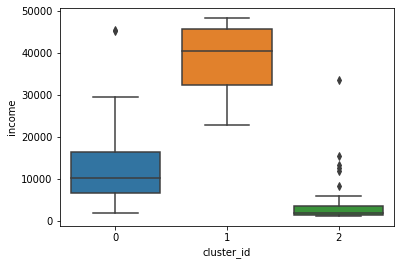

In [38]:
#plot
sns.boxplot(x='cluster_id', y='income', data=data)

**Observations**
- Cluster 1 comprises of highest income countries, Cluster 0 forms mid income and cluster 0 forms lowest income countries
- There is a huge gap between hioghest and lowest incomes' countries

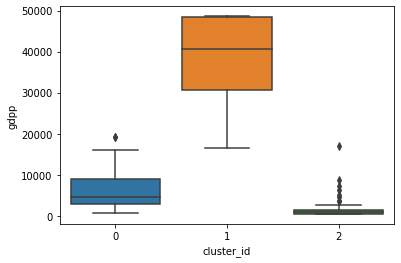

In [39]:
#plot
sns.boxplot(x='cluster_id', y='gdpp', data=data)

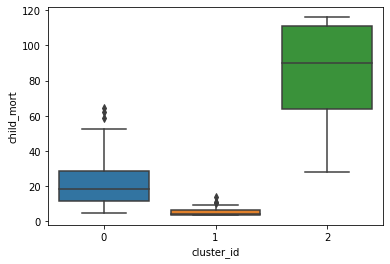

In [40]:
#plot
sns.boxplot(x='cluster_id', y='child_mort', data=data)

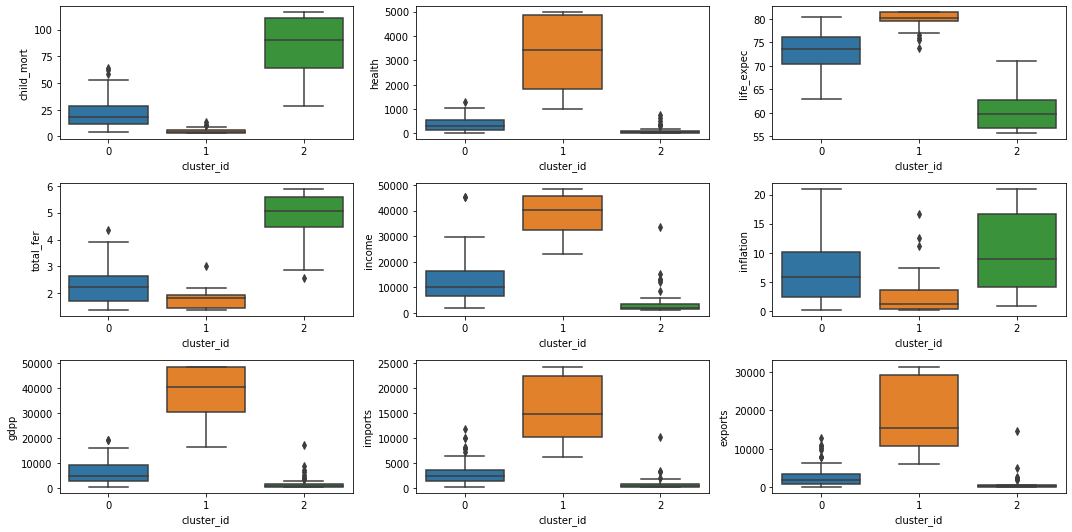

In [41]:
fig, axs = plt.subplots(3,3, figsize = (15,7.5))
plt1 = sns.boxplot(x='cluster_id', y = 'child_mort', data=data, ax = axs[0,0])
plt2 = sns.boxplot(x='cluster_id', y = 'health', data=data, ax = axs[0,1])
plt3 = sns.boxplot(x='cluster_id', y = 'life_expec', data=data, ax = axs[0,2])
plt4 = sns.boxplot(x='cluster_id', y = 'total_fer', data=data, ax = axs[1,0])
plt5 = sns.boxplot(x='cluster_id', y = 'income', data=data, ax = axs[1,1])
plt6 = sns.boxplot(x='cluster_id', y = 'inflation', data=data, ax = axs[1,2])
plt7 = sns.boxplot(x='cluster_id', y = 'gdpp', data=data, ax = axs[2,0])
plt8 = sns.boxplot(x='cluster_id', y = 'imports', data=data, ax = axs[2,1])
plt9 = sns.boxplot(x='cluster_id', y = 'exports', data=data, ax = axs[2,2])


plt.tight_layout()

**Observations**
1. We can see a direct relation between the socioeconomic factors in the above boxplots
2. The cluster with highest income group has better health, highest gdpp, higher life expectancy, higher imports and exports, lowest child mortality, lower inflation rates and lower fertility rates.
3. While the countries with lower gdpp, imports and exports have lower income, higher child mortality, inflation and fertility.

- Cluster 1 are the better placed countries in terms of socio-economic status, health and development.
- **Cluster 2 countries would need help for development as this group forms highest child mortality, lowest gdpp and lowest income group.**

### Let's see which are those countries


In [42]:
df_country['cluster_id'] = kmeans.labels_
cluster_2_kmeans = df_country[['cluster_id','country', 'child_mort', 'gdpp', 'income' ]].loc[df_final['cluster_id'] == 2].reset_index()
cluster_2_kmeans.shape

NameError: name 'df_final' is not defined

**There are 48 countries in cluster 2 which need help for development as per K-means Clustering**

In [144]:
cluster_2_kmeans.sort_values(by = ['child_mort', 'gdpp', 'income'], ascending = [False, True, True]).head(5)

,index,cluster_id,country,child_mort,gdpp,income
20,66,2,Haiti,208.0,662,1500
38,132,2,Sierra Leone,160.0,399,1220
8,32,2,Chad,150.0,897,1930
7,31,2,Central African Republic,149.0,446,888
29,97,2,Mali,137.0,708,1870


**Haiti is in the highest need for HELP foundation followed by Sierre Leone, Chad, CAR, Mali among other AFRICAN countries.**

# Hierarchical Clustering

In [123]:
df_scaled = pd.DataFrame(df_scaled)
df_scaled.head()

,0,1,2,3,4,5,6,7,8
0,1.479588,-0.668039,-0.629778,-0.733291,-0.960575,0.387667,-1.825310,2.020718,-0.757874
1,-0.560024,-0.542389,-0.473807,-0.472674,-0.395590,-0.404004,0.682454,-0.887331,-0.523775
2,-0.263504,-0.476048,-0.530344,-0.560668,-0.193907,1.452825,0.707406,-0.022587,-0.499286
3,2.194560,-0.419165,-0.589272,-0.543598,-0.669255,2.215708,-1.338729,2.049310,-0.560839
4,-0.734610,-0.027297,-0.150953,0.306143,0.227115,-0.891802,0.744836,-0.552591,0.012991


In [124]:
data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id
0,90.2,70.4688,41.9174,248.297,1610.0,9.44,56.2,5.820,553.0,2
1,16.6,1145.2000,267.8950,1987.740,9930.0,4.49,76.3,1.650,4090.0,0
2,27.3,1712.6400,185.9820,1400.440,12900.0,16.10,76.5,2.890,4460.0,0
3,116.0,2199.1900,100.6050,1514.370,5900.0,20.87,60.1,5.861,3530.0,2
4,10.3,5551.0000,735.6600,7185.800,19100.0,1.44,76.8,2.130,12200.0,0


###### Single Linkage

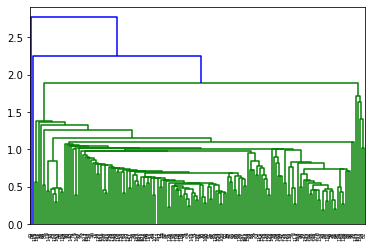

In [125]:
# single linkage
mergings = linkage(df_scaled, method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

###### Complete Linkage

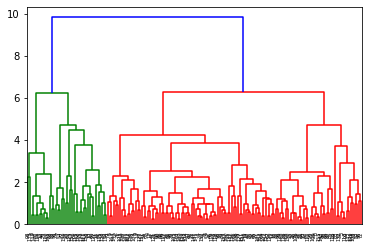

In [126]:
# complete linkage
mergings = linkage(df_scaled, method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [129]:
# 3 clusters
cluster_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels

array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 2, 1, 1, 1, 2, 1, 0, 1, 1, 1, 1,
       1, 2, 1, 0, 0, 1, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 2,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 2, 2, 0, 0, 1, 2, 0, 2, 1, 1, 0, 0, 1,
       0, 1, 2, 1, 1, 1, 0, 2, 2, 2, 1, 2, 1, 1, 0, 1, 2, 1, 0, 1, 1, 0,
       0, 2, 1, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       2, 2, 0, 0, 2, 2, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 2, 0, 1, 1,
       0, 2, 2, 2, 1, 1, 2, 2, 1, 1, 0, 1, 2, 2, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 2, 2, 2, 1, 1, 1, 1, 1, 0, 0])

In [130]:
# assign cluster labels
data['cluster_labels'] = cluster_labels
data.head()

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,cluster_id,cluster_labels
0,90.2,70.4688,41.9174,248.297,1610.0,9.44,56.2,5.820,553.0,2,0
1,16.6,1145.2000,267.8950,1987.740,9930.0,4.49,76.3,1.650,4090.0,0,1
2,27.3,1712.6400,185.9820,1400.440,12900.0,16.10,76.5,2.890,4460.0,0,1
3,116.0,2199.1900,100.6050,1514.370,5900.0,20.87,60.1,5.861,3530.0,2,0
4,10.3,5551.0000,735.6600,7185.800,19100.0,1.44,76.8,2.130,12200.0,0,1


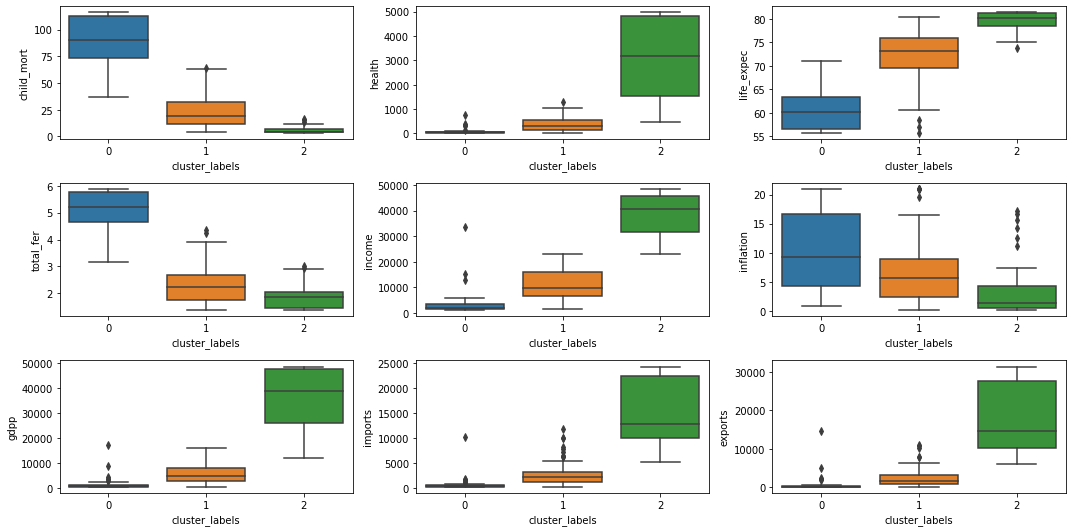

In [131]:
# plots
fig, axs = plt.subplots(3,3, figsize = (15,7.5))
plt1 = sns.boxplot(x='cluster_labels', y = 'child_mort', data=data, ax = axs[0,0])
plt2 = sns.boxplot(x='cluster_labels', y = 'health', data=data, ax = axs[0,1])
plt3 = sns.boxplot(x='cluster_labels', y = 'life_expec', data=data, ax = axs[0,2])
plt4 = sns.boxplot(x='cluster_labels', y = 'total_fer', data=data, ax = axs[1,0])
plt5 = sns.boxplot(x='cluster_labels', y = 'income', data=data, ax = axs[1,1])
plt6 = sns.boxplot(x='cluster_labels', y = 'inflation', data=data, ax = axs[1,2])
plt7 = sns.boxplot(x='cluster_labels', y = 'gdpp', data=data, ax = axs[2,0])
plt8 = sns.boxplot(x='cluster_labels', y = 'imports', data=data, ax = axs[2,1])
plt9 = sns.boxplot(x='cluster_labels', y = 'exports', data=data, ax = axs[2,2])


plt.tight_layout()

**Observations**
- Here cluster 2 forms the better placed countries in terms of socio-economic status and Cluster 0 is a group of countries which would need help with lowest gdpp, income and highest child mortality rates.

**Below are the countries which need help from HELP Foundation and the CEO should focus upon**

In [135]:
df_country['cluster_labels'] = cluster_labels
cluster_0_hc = df_country[['cluster_labels','country', 'child_mort', 'gdpp', 'income' ]].loc[df_country['cluster_labels'] == 0].reset_index()
cluster_0_hc.shape

(43, 6)

In [147]:
cluster_0_hc.sort_values(by = ['child_mort', 'gdpp', 'income'], ascending = [False, True, True]).head(5)

,index,cluster_labels,country,child_mort,gdpp,income
19,66,0,Haiti,208.0,662,1500
35,132,0,Sierra Leone,160.0,399,1220
7,32,0,Chad,150.0,897,1930
6,31,0,Central African Republic,149.0,446,888
27,97,0,Mali,137.0,708,1870


### We can see that both K means and Hierarchical clustering with K=3 gave us similar results. We are able to group the countries which we can provide to HELP international CEO to focus on the most.

- There are 43-48 backward countries which HELP international CEO should target to focus on.

**Top 5 of those are:
1. Haiti
2. Sierra Leone
3. Chad
4. Central African Republic
5. Mali**

among other African countries.